          Date       Close
884 2014-01-02  150.100006
885 2014-01-03  149.559998
886 2014-01-06  147.000000
887 2014-01-07  149.360001
888 2014-01-08  151.279999
           Date       Close
1635 2016-12-23  213.339996
1636 2016-12-27  219.529999
1637 2016-12-28  219.740005
1638 2016-12-29  214.679993
1639 2016-12-30  213.690002


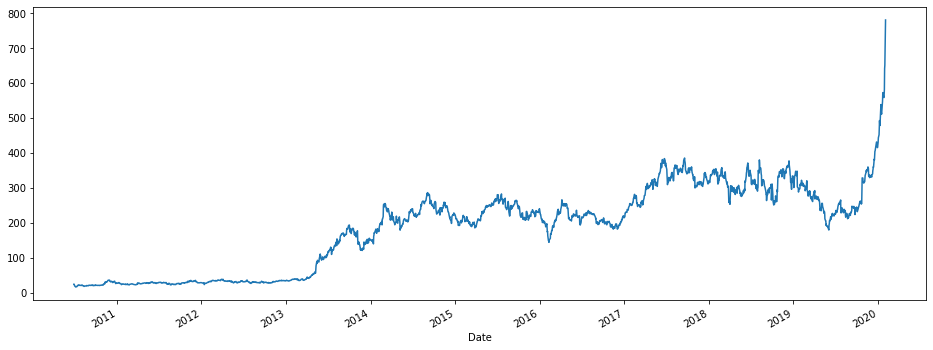

In [1]:

# Importing modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pandas_datareader as web
from datetime import datetime

# end=datetime.now()
# #start = datetime(end.year - 1, end.month, end.day)
# tesla=web.DataReader('TSLA',data_source='yahoo',start='2018-01-01',end=end)
# assert None == tesla.to_csv("Stock.csv")
# Reading in the data
# tesla = pd.read_excel('Stock.xls')
tesla = pd.read_excel('TSLA.xlsx')
tesla.head()
# Isolating the date and Close price
tesla = tesla[['Date', 'Close']]
tesla.head()
# Converting the date series to a datetime object
tesla.Date = pd.to_datetime(tesla.Date, format = '%Y/%m/%d')

# Setting the index 
plot_tesla = tesla.set_index('Date')
plot_tesla['Close'].plot(figsize=(16,6))
new_tesla = tesla.loc[884:1639]
# new_tesla = tesla
print(new_tesla.head())

print(new_tesla.tail())


In [2]:
new_tesla = new_tesla.drop('Date', axis = 1)
new_tesla = new_tesla.reset_index(drop = True)
new_tesla.head()




,Close
0,150.100006
1,149.559998
2,147.000000
3,149.360001
4,151.279999


In [3]:
T = new_tesla.values

T = T.astype('float32')

T = np.reshape(T, (-1, 1))


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
T = scaler.fit_transform(T)

# 80-20 split
train_size = int(len(T) * 0.80)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]

# Method for create features from the time series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

# Roughly one month of trading assuming 5 trading days per week
window_size = 20
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)

# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Checking to make sure that none of our training set is leaking into the testing set
T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

# Make sure that the number of rows in the dataset = train rows + test rows
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(T_shape, train_shape, test_shape))

# Model imports
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint


# Setting seed for reproducibility 
tf.random.set_seed(11)
np.random.seed(11)

# Building model
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, 
               input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

filepath = 'saved_models/model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode ='min'
                            )

history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, validation_data = (X_test, Y_test), 
                    callbacks = [checkpoint], 
                    verbose = 1, shuffle = False)

model.summary()



False
Epoch 1/100
10/30 [=========>....................] - ETA: 0s - loss: 0.3910  

In [ ]:
from keras.models import load_model

best_model = load_model('saved_models/model_epoch_88.hdf5')

# Predicting and inverse transforming the predictions

train_predict = best_model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

# Inverse transforming the actual values, to return them to their original values
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

Y_test

In [ ]:

Y_hat_train = np.reshape(Y_hat_train, newshape = 583)
Y_hat_test = np.reshape(Y_hat_test, newshape = 131)

Y_train = np.reshape(Y_train, newshape = 583)
Y_test = np.reshape(Y_test, newshape = 131)

# Y_hat_train = np.reshape(Y_hat_train, newshape = 1911)
# Y_hat_test = np.reshape(Y_hat_test, newshape = 463)

# Y_train = np.reshape(Y_train, newshape = 1911)
# Y_test = np.reshape(Y_test, newshape = 463)


# Y_hat_train = np.reshape(Y_hat_train, newshape = 626)
# Y_hat_test = np.reshape(Y_hat_test, newshape = 141)

# Y_train = np.reshape(Y_train, newshape = 626)
# Y_test = np.reshape(Y_test, newshape = 141)

In [ ]:

from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

In [ ]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

In [ ]:
result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat


result_df.head()

In [ ]:
result_df.plot()